In [1]:
!pip install scikit-learn

   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
    --------------------------------------- 0.3/11.1 MB ? eta -:--:--
   - -------------------------------------- 0.5/11.1 MB 1.3 MB/s eta 0:00:09
   -- ------------------------------------- 0.8/11.1 MB 1.3 MB/s eta 0:00:09
   --- ------------------------------------ 1.0/11.1 MB 1.3 MB/s eta 0:00:08
   ---- ----------------------------------- 1.3/11.1 MB 1.3 MB/s eta 0:00:08
   ------ --------------------------------- 1.8/11.1 MB 1.4 MB/s eta 0:00:07
   ------- -------------------------------- 2.1/11.1 MB 1.4 MB/s eta 0:00:07
   -------- ------------------------------- 2.4/11.1 MB 1.4 MB/s eta 0:00:07
   --------- ------------------------------ 2.6/11.1 MB 1.4 MB/s eta 0:00:06
   ---------- ----------------------------- 2.9/11.1 MB 1.4 MB/s eta 0:00:06
   ----------- ---------------------------- 3.1/11.1 MB 1.4 MB/s eta 0:00:06
   ------------ --------------------------- 3.4/11.1 MB 1.4 MB/s eta 0:00:06
   ----------


[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Step 1: Load Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

In [4]:
data_dict = pd.read_csv("TOURNAMENT_DATA/DataDictionary - Sheet1.csv")
regional_games = pd.read_csv("TOURNAMENT_DATA/East Regional Games to predict - Sheet1.csv")
games_2022 = pd.read_csv("TOURNAMENT_DATA/games_2022 (edited) - games_2022.csv")
team_regions = pd.read_csv("TOURNAMENT_DATA/Team Region Groups - Sheet1.csv")

In [40]:
games_2022.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9826 entries, 0 to 9825
Data columns (total 35 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   game_id              9826 non-null   object        
 1   game_date            9826 non-null   datetime64[ns]
 2   team                 9826 non-null   object        
 3   fga_2                9826 non-null   int64         
 4   fgm_2                9826 non-null   int64         
 5   fga_3                9826 non-null   int64         
 6   fgm_3                9826 non-null   int64         
 7   fta                  9826 non-null   int64         
 8   ftm                  9826 non-null   int64         
 9   ast                  9826 non-null   int64         
 10  blk                  9826 non-null   int64         
 11  stl                  9826 non-null   int64         
 12  tov                  9826 non-null   int64         
 13  tov_team             9826 non-nul

### Step 2: Data Cleaning & Preprocessing

In [5]:
regional_games.columns = regional_games.columns.str.lower().str.replace(" ", "_")
games_2022.columns = games_2022.columns.str.lower().str.replace(" ", "_")
team_regions.columns = team_regions.columns.str.lower().str.replace(" ", "_")

In [6]:
games_2022["game_date"] = pd.to_datetime(games_2022["game_date"], errors="coerce")

games_2022 = games_2022.merge(team_regions, on="team", how="left")

In [7]:
regional_games = regional_games.merge(
    team_regions.rename(columns={"team": "team_home", "region": "region_home"}),
    on="team_home",
    how="left"
)
regional_games = regional_games.merge(
    team_regions.rename(columns={"team": "team_away", "region": "region_away"}),
    on="team_away",
    how="left"
)

In [8]:
num_cols = ["largest_lead", "ot_length_min_tot", "rest_days", "attendance", "tz_dif_h_e", "prev_game_dist", "travel_dist"]
for col in num_cols:
    if col in games_2022.columns:
        games_2022[col].fillna(games_2022[col].median(), inplace=True)

C:\Users\devmo\AppData\Local\Temp\ipykernel_26312\306474479.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  games_2022[col].fillna(games_2022[col].median(), inplace=True)
C:\Users\devmo\AppData\Local\Temp\ipykernel_26312\306474479.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a co

In [9]:
print("Games 2022 - Summary Statistics:")
print(games_2022.describe())

Games 2022 - Summary Statistics:
                           game_date        fga_2        fgm_2        fga_3  \
count                           9826  9826.000000  9826.000000  9826.000000   
mean   2022-01-12 06:07:15.253409024    39.631895    17.641360    18.922451   
min              2021-11-09 00:00:00     9.000000     3.000000     1.000000   
25%              2021-12-07 00:00:00    34.000000    14.000000    14.000000   
50%              2022-01-20 00:00:00    39.000000    17.000000    18.000000   
75%              2022-02-12 00:00:00    45.000000    21.000000    23.000000   
max              2022-03-13 00:00:00    71.000000    40.000000    56.000000   
std                              NaN     8.051460     4.882561     6.475815   

             fgm_3          fta          ftm          ast          blk  \
count  9826.000000  9826.000000  9826.000000  9826.000000  9826.000000   
mean      5.844494    16.073275    11.361388    12.908610     3.187055   
min       0.000000     0.000000  

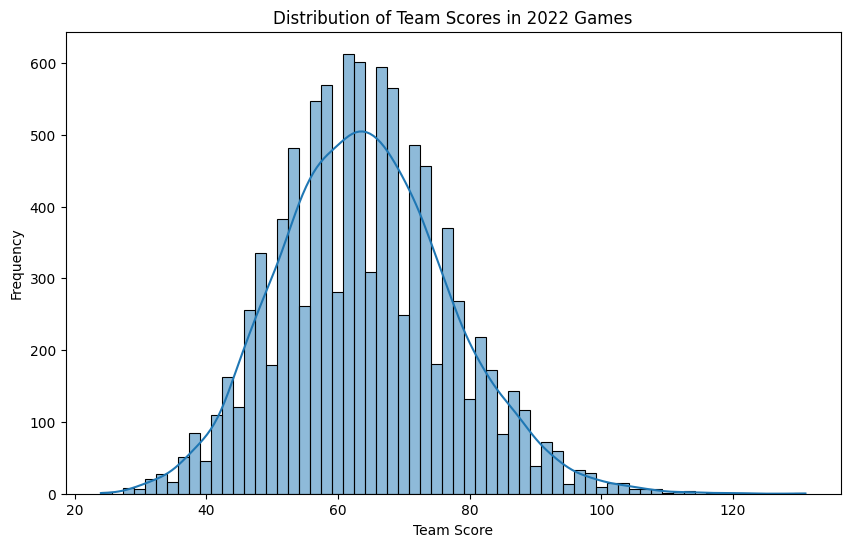

In [10]:
plt.figure(figsize=(10, 6))
sns.histplot(games_2022["team_score"], kde=True)
plt.title("Distribution of Team Scores in 2022 Games")
plt.xlabel("Team Score")
plt.ylabel("Frequency")
plt.show()

### Step 3: Feature Engineering

In [11]:
games_2022["fg_pct_2"] = games_2022["fgm_2"] / games_2022["fga_2"]
games_2022["fg_pct_3"] = games_2022["fgm_3"] / games_2022["fga_3"]
games_2022["ft_pct"] = games_2022["ftm"] / games_2022["fta"]

In [12]:
games_2022["point_diff"] = games_2022["team_score"] - games_2022["opponent_team_score"]

games_2022["win"] = (games_2022["team_score"] > games_2022["opponent_team_score"]).astype(int)

In [13]:
team_agg = games_2022.groupby("team").agg({
    "win": ["mean", "sum"],
    "team_score": "mean",
    "opponent_team_score": "mean",
    "fg_pct_2": "mean",
    "fg_pct_3": "mean",
    "ft_pct": "mean",
    "ast": "mean",
    "blk": "mean",
    "stl": "mean",
    "tov": "mean",
    "point_diff": "mean"
})

In [14]:
team_agg.columns = ["_".join(col).strip() for col in team_agg.columns.values]
team_agg = team_agg.reset_index()
team_agg.rename(columns={"win_mean": "win_percentage", "win_sum": "total_wins"}, inplace=True)
team_agg = team_agg.merge(team_regions, on="team", how="left")

In [15]:
print("\nTop 5 Teams by Win Percentage:")
print(team_agg.sort_values("win_percentage", ascending=False).head())


Top 5 Teams by Win Percentage:
                          team  win_percentage  total_wins  team_score_mean  \
262   south_carolina_gamecocks        0.935484          29        71.290323   
85   florida_gulf_coast_eagles        0.923077          24        75.923077   
182          nc_state_wolfpack        0.906250          29        76.375000   
278          stanford_cardinal        0.903226          28        73.774194   
138             liberty_flames        0.888889          24        65.555556   

     opponent_team_score_mean  fg_pct_2_mean  fg_pct_3_mean  ft_pct_mean  \
262                 51.677419       0.476529       0.315578     0.676142   
85                  58.461538       0.574094       0.333584     0.643437   
182                 57.031250       0.508094       0.367841     0.767493   
278                 56.870968       0.500605       0.358444     0.673766   
138                 53.518519       0.510495       0.309155     0.669819   

      ast_mean  blk_mean  stl_mean  

### Step 4: Use Elo Ranking System

In [16]:
all_teams = pd.concat([games_2022["team"], games_2022["team"]]).unique()
elo_ratings = {team: 1500 for team in all_teams}

In [17]:
def expected_score(rating_a, rating_b):
    """Calculate expected score for team A against team B."""
    return 1 / (1 + 10 ** ((rating_b - rating_a) / 400))

In [18]:
grouped_games = games_2022.groupby("game_id")
k = 20  

In [19]:
for game_id, group in grouped_games:
    if group.shape[0] != 2:
        continue  
    if "home" in group["home_away"].values and "away" in group["home_away"].values:
        home_row = group[group["home_away"] == "home"].iloc[0]
        away_row = group[group["home_away"] == "away"].iloc[0]
    else:
        home_row = group.iloc[0]
        away_row = group.iloc[1]
    
    home_team = home_row["team"]
    away_team = away_row["team"]
    home_score = home_row["team_score"]
    away_score = away_row["team_score"]
    
    outcome_home = 1 if home_score > away_score else 0
    outcome_away = 1 - outcome_home
    
    expected_home = expected_score(elo_ratings[home_team], elo_ratings[away_team])
    expected_away = expected_score(elo_ratings[away_team], elo_ratings[home_team])
    
    elo_ratings[home_team] += k * (outcome_home - expected_home)
    elo_ratings[away_team] += k * (outcome_away - expected_away)

In [20]:
team_agg["elo_rating"] = team_agg["team"].apply(lambda t: elo_ratings.get(t, 1500))

In [21]:
regional_games["elo_home"] = regional_games["team_home"].apply(lambda t: elo_ratings.get(t, 1500))
regional_games["elo_away"] = regional_games["team_away"].apply(lambda t: elo_ratings.get(t, 1500))
regional_games["expected_home"] = 1 / (1 + 10 ** ((regional_games["elo_away"] - regional_games["elo_home"]) / 400))
regional_games["predicted_winning_%_elo"] = regional_games["expected_home"]

In [22]:
print("\nRegional Games Predictions using ELO:")
print(regional_games[["game_id", "team_home", "team_away", "predicted_winning_%_elo"]].head())


Regional Games Predictions using ELO:
    game_id          team_home                 team_away  \
0  G_East_1  rhode_island_rams  north_carolina_tar_heels   
1  G_East_2  nc_state_wolfpack         rhode_island_rams   
2  G_East_3  nc_state_wolfpack  north_carolina_tar_heels   
3  G_East_4     liberty_flames            bucknell_bison   
4  G_East_5     drexel_dragons        delaware_blue_hens   

   predicted_winning_%_elo  
0                 0.503734  
1                 0.625175  
2                 0.628668  
3                 0.571474  
4                 0.508850  


In [23]:
team_agg["combined_rank_score"] = team_agg["win_percentage"] * 0.5 + (team_agg["elo_rating"] / 3000) * 0.5
team_agg.sort_values("combined_rank_score", ascending=False, inplace=True)

In [24]:
print("\nTeam Rankings based on Combined Score:")
print(team_agg[["team", "win_percentage", "elo_rating", "combined_rank_score"]].head())


Team Rankings based on Combined Score:
                          team  win_percentage   elo_rating  \
262   south_carolina_gamecocks        0.935484  1707.349408   
85   florida_gulf_coast_eagles        0.923077  1671.877632   
182          nc_state_wolfpack        0.906250  1710.561783   
278          stanford_cardinal        0.903226  1699.737450   
307                ucf_knights        0.888889  1668.665847   

     combined_rank_score  
262             0.752300  
85              0.740185  
182             0.738219  
278             0.734902  
307             0.722555  


### Step 5: Train Logistic Regression Model

In [25]:
games_home = games_2022[games_2022["home_away"] == "home"][["game_id", "team", "win"]].rename(columns={"team": "team_home", "win": "win_home"})
games_away = games_2022[games_2022["home_away"] == "away"][["game_id", "team", "win"]].rename(columns={"team": "team_away", "win": "win_away"})

In [26]:
matchups = pd.merge(games_home, games_away, on="game_id")

features = ['win_percentage', 'team_score_mean', 'fg_pct_2_mean', 'fg_pct_3_mean', 
            'ft_pct_mean', 'ast_mean', 'blk_mean', 'stl_mean', 'tov_mean', 'point_diff_mean', 'elo_rating']

In [27]:
matchups = matchups.merge(team_agg[['team'] + features], left_on='team_home', right_on='team', how='left') \
                   .drop("team", axis=1) \
                   .rename(columns={f: f"{f}_home" for f in features})

matchups = matchups.merge(team_agg[['team'] + features], left_on='team_away', right_on='team', how='left') \
                   .drop("team", axis=1) \
                   .rename(columns={f: f"{f}_away" for f in features})

In [28]:
for f in features:
    matchups[f + "_diff"] = matchups[f + "_home"] - matchups[f + "_away"]

In [29]:
X = matchups[[f + "_diff" for f in features]]
y = matchups["win_home"]

In [30]:
X

,win_percentage_diff,team_score_mean_diff,fg_pct_2_mean_diff,fg_pct_3_mean_diff,ft_pct_mean_diff,ast_mean_diff,blk_mean_diff,stl_mean_diff,tov_mean_diff,point_diff_mean_diff,elo_rating_diff
0,0.335484,0.990323,-0.018710,-0.056755,-0.057828,0.760215,5.907527,0.723656,-0.088172,16.246237,148.518283
1,0.175269,-0.597849,-0.016071,-0.037111,-0.073394,3.445161,2.967742,-2.609677,1.993548,4.341935,74.102812
2,-0.209524,-6.819048,-0.046775,-0.055941,-0.057131,0.014286,0.428571,-0.435714,-0.235714,-7.578571,-86.259132
3,0.161290,-3.806452,-0.016348,-0.025003,-0.041774,1.903226,1.000000,-1.064516,5.903226,1.709677,65.541845
4,0.001152,0.733871,0.011524,0.011128,0.005424,3.708525,2.827189,-0.299539,-0.699309,6.239631,-0.474910
...,...,...,...,...,...,...,...,...,...,...,...
2509,-0.642963,-12.586667,-0.036768,-0.037433,-0.046886,-0.077037,-1.629630,-0.362963,3.177778,-20.801481,-244.708278
2510,0.189231,3.341538,0.050556,-0.019081,0.028492,2.364615,2.043077,-1.144615,-1.033846,10.981538,64.073260
2511,-0.383142,-1.011494,-0.013812,-0.020215,-0.115839,-1.627075,-0.008940,-1.192848,4.467433,-20.914432,-144.576521
2512,-0.312903,-6.956989,-0.042689,-0.076158,-0.027751,-2.552688,-0.484946,-0.016129,3.624731,-11.887097,-154.649866


In [31]:
print("Missing values in X before imputation:")
print(X.isnull().sum())

Missing values in X before imputation:
win_percentage_diff     0
team_score_mean_diff    0
fg_pct_2_mean_diff      0
fg_pct_3_mean_diff      0
ft_pct_mean_diff        0
ast_mean_diff           0
blk_mean_diff           0
stl_mean_diff           0
tov_mean_diff           0
point_diff_mean_diff    0
elo_rating_diff         0
dtype: int64


In [32]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [33]:
imputer = SimpleImputer(strategy="median")
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

In [34]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train_imputed, y_train)

LogisticRegression(max_iter=1000)

In [35]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]
accuracy = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_prob)
print(f"\nLogistic Regression Model - Accuracy: {accuracy:.3f}, ROC AUC: {roc_auc:.3f}")


Logistic Regression Model - Accuracy: 0.793, ROC AUC: 0.883


C:\Users\devmo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(
C:\Users\devmo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


Logistic Regression Model (uneditted games.csv) - Accuracy: 0.787, ROC AUC: 0.869

### Step 6: Prediction

In [36]:
regional_games = regional_games.merge(team_agg[['team'] + features], left_on='team_home', right_on='team', how='left') \
                               .drop("team", axis=1) \
                               .rename(columns={f: f"{f}_home" for f in features})
regional_games = regional_games.merge(team_agg[['team'] + features], left_on='team_away', right_on='team', how='left') \
                               .drop("team", axis=1) \
                               .rename(columns={f: f"{f}_away" for f in features})

In [37]:
for f in features:
    regional_games[f+ "_diff"] = regional_games[f + "_home"] - regional_games[f + "_away"]

In [38]:
predictor_cols = [f + "_diff" for f in features]
regional_games["predicted_prob_model"] = model.predict_proba(regional_games[predictor_cols])[:, 1]

C:\Users\devmo\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


In [39]:
print("\nRegional Games Predictions using Logistic Regression Model:")
print(regional_games[["game_id", "team_home", "team_away", "predicted_prob_model"]][:10])


Regional Games Predictions using Logistic Regression Model:
     game_id                   team_home                 team_away  \
0   G_East_1           rhode_island_rams  north_carolina_tar_heels   
1   G_East_2           nc_state_wolfpack         rhode_island_rams   
2   G_East_3           nc_state_wolfpack  north_carolina_tar_heels   
3   G_East_4              liberty_flames            bucknell_bison   
4   G_East_5              drexel_dragons        delaware_blue_hens   
5   G_East_6   massachusetts_minutewomen          princeton_tigers   
6   G_East_7               buffalo_bulls     stony_brook_seawolves   
7   G_East_8             fairfield_stags             towson_tigers   
8   G_East_9               uconn_huskies  campbell_fighting_camels   
9  G_East_10  american_university_eagles            columbia_lions   

   predicted_prob_model  
0              0.474914  
1              0.813962  
2              0.803760  
3              0.661280  
4              0.644856  
5           